## Shells or Pebbles: An Image Classification Dataset
https://www.kaggle.com/datasets/vencerlanz09/shells-or-pebbles-an-image-classification-dataset

## 라이브러리

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 함수 정의

In [ ]:
# 레이블이 있는 데이터 경로 생성
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# 레이블이 있는 데이터 경로를 하나의 데이터 프레임으로 연결
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# 학습, 검증, 테스트 데이터로 나누기
def split_data(data_dir):
    # 학습
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # 검증및 테스트 데이터
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df


def preprocess_image(image_path):
    image = load_img(image_path, target_size=input_shape)
    image = img_to_array(image) / 255.0  # 이미지를 0~1 사이의 값으로 정규화
    return image

def data_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        indices = np.random.choice(num_samples, size=batch_size, replace=False)
        batch_images = []
        batch_labels = []
        for index in indices:
            image = preprocess_image(image_paths[index])
            label = labels[index]
            batch_images.append(image)
            batch_labels.append(label)
        yield np.array(batch_images), np.array(batch_labels)

def process_data(data_image_list):
    data_df = []
    for i,img in enumerate(data_image_list):
        img = cv2.imread(img,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        data_df.append(np.array(img))
        display.clear_output(wait = True)
        display.display(i)
    return np.array(data_df)

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

## 데이터 준비

In [ ]:
# 데이터셋과 레이블 파일 경로 설정
dataset_path = '/content/drive/MyDrive/archive6'

In [ ]:
# CSV 파일에서 이미지 파일 경로와 클래스 정보 로드
image_paths, labels = define_paths(dataset_path)

label_mapping = {'Shells': 0, 'Pebbles': 1}
labels = [label_mapping[label] for label in labels]

In [ ]:
# 데이터셋 분할: 학습 데이터와 검증 데이터
train_paths, valid_paths, train_labels, valid_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [ ]:
num_classes = 2

train_labels = to_categorical(train_labels, num_classes)
valid_labels = to_categorical(valid_labels, num_classes)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=4)

## 데이터 전처리

In [ ]:
# 이미지 전처리 및 데이터 제너레이터 설정
input_shape = (224, 224, 3)  # 입력 이미지 크기 설정
batch_size = 32

In [ ]:
targets = labels
inputs = process_data(image_paths)

4290

In [ ]:
train_gen = data_generator(train_paths, train_labels, batch_size)
valid_gen = data_generator(valid_paths, valid_labels, batch_size)

In [ ]:
inputs = []
targets = []
files = []
classes = []

## 모델 정의

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=2, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

## 모델 컴파일

In [ ]:
# 모델 컴파일
model = Model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

## 모델 학습

In [ ]:
history = model.fit(train_gen, epochs=10, steps_per_epoch=len(train_paths)//batch_size, validation_data=valid_gen, validation_steps=len(valid_paths)//batch_size)

Epoch 1/10
107/107 [==============================] - 245s 2s/step - loss: 0.7724 - accuracy: 0.6595 - val_loss: 0.6337 - val_accuracy: 0.6562
Epoch 2/10
107/107 [==============================] - 223s 2s/step - loss: 0.5496 - accuracy: 0.7188 - val_loss: 0.6715 - val_accuracy: 0.6575
Epoch 3/10
107/107 [==============================] - 215s 2s/step - loss: 0.4578 - accuracy: 0.7938 - val_loss: 0.6994 - val_accuracy: 0.6911
Epoch 4/10
107/107 [==============================] - 219s 2s/step - loss: 0.3518 - accuracy: 0.8569 - val_loss: 0.7184 - val_accuracy: 0.6442
Epoch 5/10
107/107 [==============================] - 221s 2s/step - loss: 0.2382 - accuracy: 0.9118 - val_loss: 1.2880 - val_accuracy: 0.6731
Epoch 6/10
107/107 [==============================] - 240s 2s/step - loss: 0.1667 - accuracy: 0.9501 - val_loss: 1.0949 - val_accuracy: 0.6935
Epoch 7/10
107/107 [==============================] - 226s 2s/step - loss: 0.1084 - accuracy: 0.9725 - val_loss: 1.0783 - val_accuracy: 0.6611

## 결과 시각화

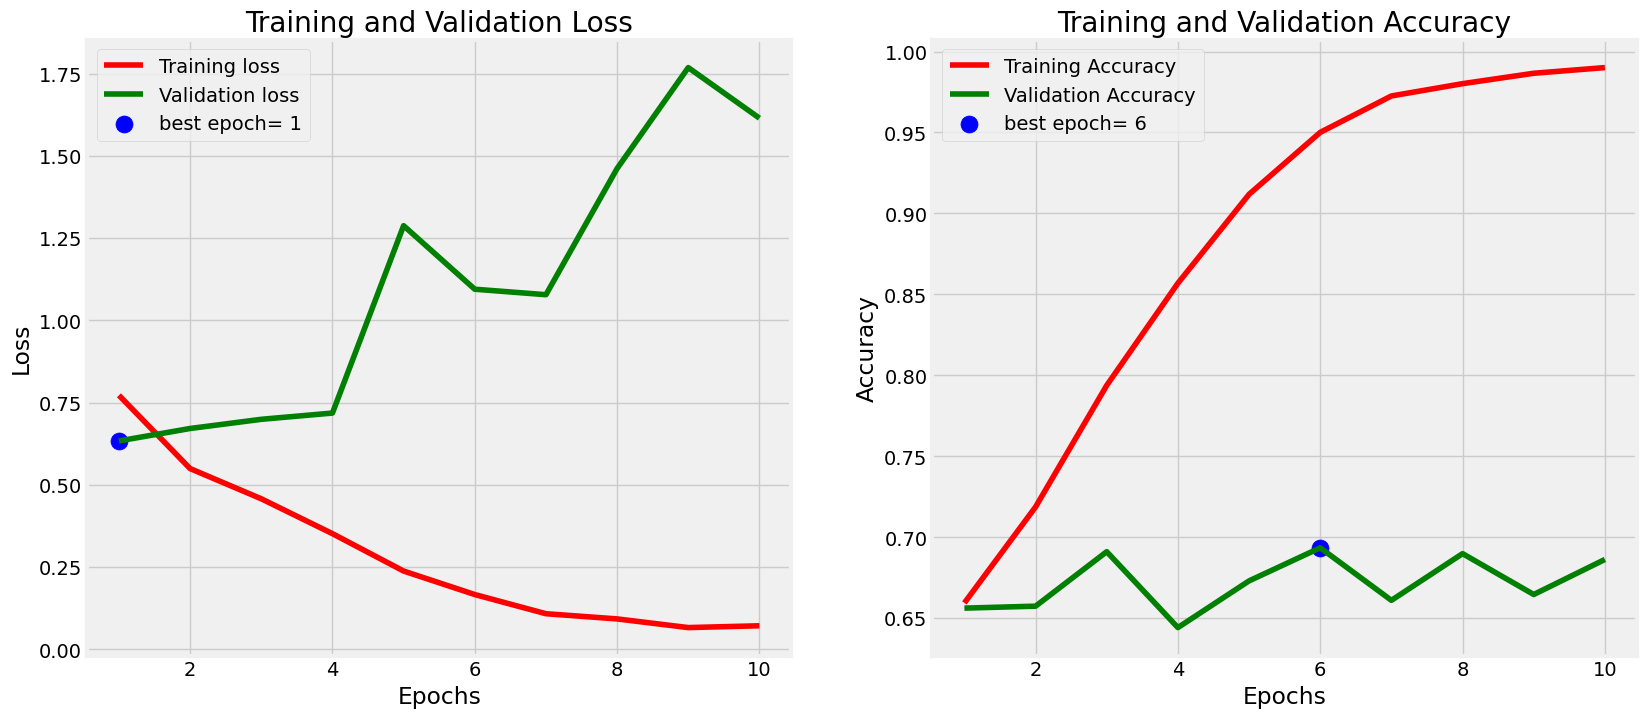

In [ ]:
plot_training(history)